In [170]:
import numpy as np
import sqlite3 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white", {'axes.edgecolor': '#EAEAF2'})
sns.set_context("notebook", font_scale=1.25) 


In [31]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [32]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [33]:
def show_tables():
    q = '''SELECT name,type
           FROM sqlite_master
           WHERE type IN ("table","view");'''
    return run_query(q)

In [34]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [87]:
q = '''
WITH 
    us_invoices AS
    (
    SELECT 
        DISTINCT il.invoice_id, 
        SUM(il.quantity) num_of_tracks
    FROM invoice_line il
    INNER JOIN invoice iv ON iv.invoice_id = il.invoice_id
    INNER JOIN customer cu ON cu.customer_id = iv.customer_id
    WHERE cu.country = 'USA'
    GROUP BY 1
    )

SELECT
    g.name genre, 
    SUM(il.quantity) num_tracks_sold,
    CAST(SUM(il.quantity) AS FLOAT)/CAST((SELECT SUM(num_of_tracks) FROM us_invoices) AS FLOAT) * 100 pct_tracks_sold
FROM invoice_line il
INNER JOIN track ON track.track_id = il.track_id
INNER JOIN genre g ON g.genre_id = track.genre_id
WHERE il.invoice_id IN (SELECT invoice_id FROM us_invoices)
GROUP BY genre
ORDER BY num_tracks_sold DESC'''

genre_list = run_query(q)

In [37]:
genre_list.head()

,genre,num_tracks_sold,pct_tracks_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309


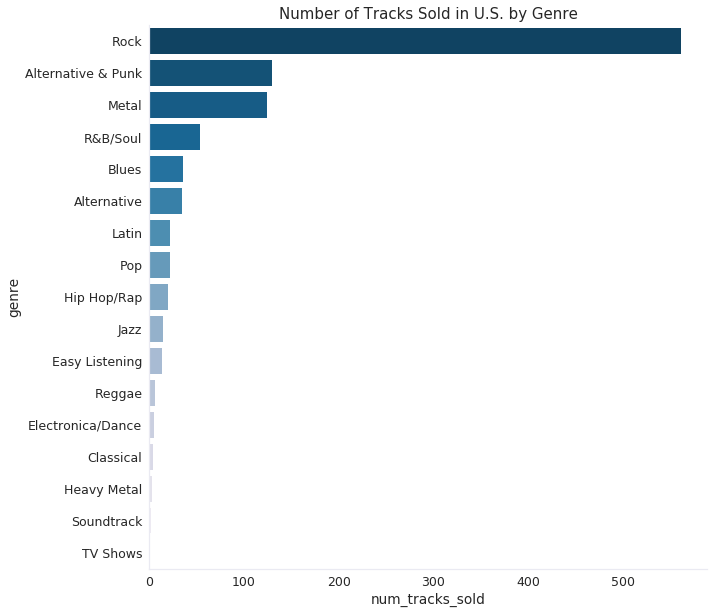

In [179]:
plt.figure(figsize=(10,10))
sns.barplot(x='num_tracks_sold', 
            y='genre', 
            data=genre_list, 
            palette=sns.color_palette("PuBu_r", 17)
           ).set_title('Number of Tracks Sold in U.S. by Genre');
sns.despine()

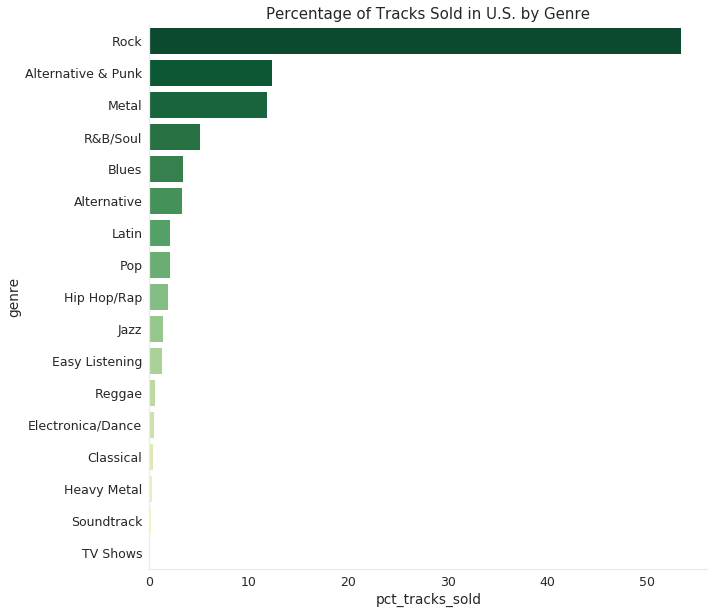

In [180]:
plt.figure(figsize=(10,10))
sns.barplot(x='pct_tracks_sold', 
            y='genre', 
            data=genre_list, 
            palette=sns.color_palette("YlGn_r", 17)
           ).set_title('Percentage of Tracks Sold in U.S. by Genre');
sns.despine()

The following artists and genres are up for consideration for adding to the store.  

-  Regal: 	Hip-Hop
-  Red Tone: 	Punk
-  Meteor and the Girls: 	Pop
-  Slim Jim Bites 	Blues:

Based on the results above, the three best selling genres in that list are:

-  Punk
-  Blues
-  Pop

Therefore, it makes the most sense to add the following three artists to the store:

-  Red Tone
-  Slim Jim Bites
-  Meteor and the Girls

In [88]:
q = '''

WITH
cust_total AS
(
    SELECT 
        c.support_rep_id,
        SUM(iv.total) total_sales
    FROM customer c
    INNER JOIN invoice iv ON iv.customer_id = c.customer_id
    GROUP BY 1

)


SELECT
    e.first_name || ' ' || e.last_name name,
    e.title,
    e.birthdate,
    e.hire_date,
    t.total_sales
FROM employee e
INNER JOIN (SELECT * FROM cust_total) t
ON t.support_rep_id = e.employee_id

'''

emp_sales = run_query(q)

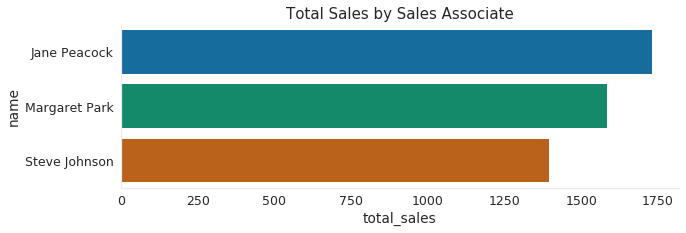

In [173]:
plt.figure(figsize=(10,3))
sns.barplot(x='total_sales',
            y='name',
            data=emp_sales,
            palette=sns.color_palette("colorblind")
           ).set_title('Total Sales by Sales Associate');
sns.despine()

All three Sales Associates are quite close in total sales.  If there is any statistical inference to be made here it is that the female Sales Associates are making more sales than the male Sales Associates.  Although with a male sample size of 1, this is hardly representative.

In [105]:
q = '''

WITH
country_multiple AS
(
    SELECT
        c.country,
        COUNT(c.customer_id) num_customers
    FROM customer c
    GROUP BY c.country
    HAVING num_customers > 1
),

country_stats AS
(
    SELECT 
        CASE
            WHEN c.country IN (SELECT country FROM country_multiple)
            THEN c.country
            ELSE 'Other'
        END AS new_country,
        SUM(i.total) as total_sales,
        COUNT(DISTINCT c.customer_id) as total_customers,
        COUNT(i.invoice_id) as total_orders
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY new_country
)

SELECT 
    CASE
        WHEN new_country = 'Other'
        THEN 1
        ELSE 0
    END sort,
    new_country country,
    total_sales,
    total_customers,
    total_sales/total_customers avg_val_per_customer,
    total_sales/total_orders avg_val_per_order
FROM country_stats
ORDER BY sort, total_sales DESC


'''

country_sales = run_query(q)

In [110]:
country_sales.round({'avg_val_per_customer': 2, 'avg_val_per_order': 2})

,sort,country,total_sales,total_customers,avg_val_per_customer,avg_val_per_order
0,0,USA,1040.49,13,80.04,7.94
1,0,Canada,535.59,8,66.95,7.05
2,0,Brazil,427.68,5,85.54,7.01
3,0,France,389.07,5,77.81,7.78
4,0,Germany,334.62,4,83.66,8.16
5,0,Czech Republic,273.24,2,136.62,9.11
6,0,United Kingdom,245.52,3,81.84,8.77
7,0,Portugal,185.13,2,92.57,6.38
8,0,India,183.15,2,91.57,8.72
9,1,Other,1094.94,15,73.00,7.45


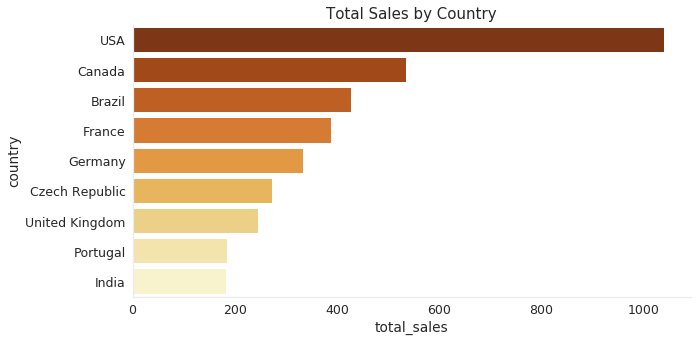

In [174]:
plt.figure(figsize=(10,5))
sns.barplot(x='total_sales',
            y='country', 
            data=country_sales[country_sales['country'] != 'Other'],
            palette=sns.color_palette("YlOrBr_r", 9)
           ).set_title('Total Sales by Country');
sns.despine()

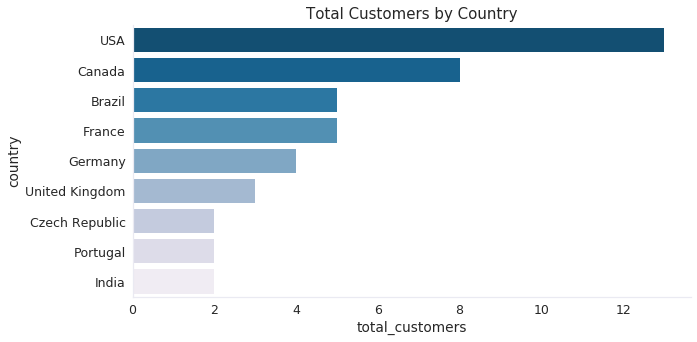

In [175]:
plt.figure(figsize=(10,5))
sns.barplot(x='total_customers',
            y='country', 
            data=country_sales[country_sales['country'] != 'Other'].sort_values(by=['total_customers'], ascending=False),
            palette=sns.color_palette("PuBu_r", 9)
           ).set_title('Total Customers by Country');
sns.despine()

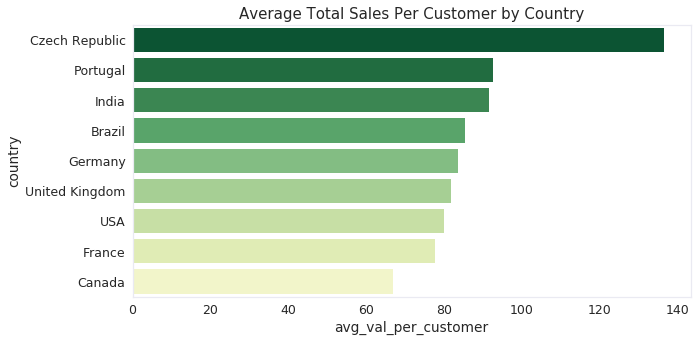

In [176]:
plt.figure(figsize=(10,5))
sns.barplot(x='avg_val_per_customer',
            y='country', 
            data=country_sales[country_sales['country'] != 'Other'].sort_values(by=['avg_val_per_customer'], ascending=False),
            palette=sns.color_palette("YlGn_r", 9)
           ).set_title('Average Total Sales Per Customer by Country');

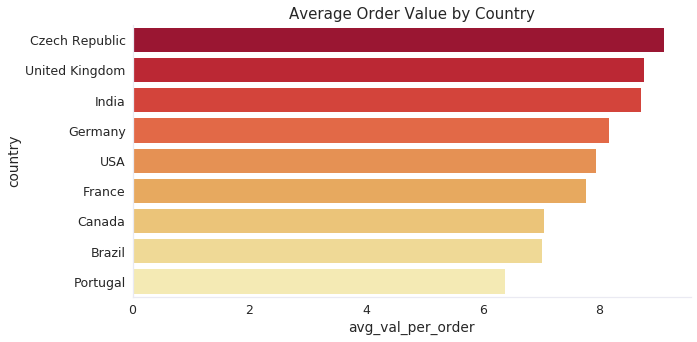

In [177]:
plt.figure(figsize=(10,5))
sns.barplot(x='avg_val_per_order',
            y='country', 
            data=country_sales[country_sales['country'] != 'Other'].sort_values(by=['avg_val_per_order'], ascending=False),
            palette=sns.color_palette("YlOrRd_r", 9)
           ).set_title('Average Order Value by Country');
sns.despine()